# Code to use and work with c302

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
%pwd

'/Users/manuel/openworm_tools'

In [4]:
#%cd c302/

In [5]:
# To clear output - Press 'ESC' + 'R' + 'Y' + 'Enter'
# !./fast_run_1 FWandBW_tries

## Functions

**Read Data -** Creates an array without the first column (time values) 

**Prepare Array -** Changes the array so that it can be represented in a given number of time measures 

**Plot Data -** Makes a plot using the data given, the legend introduced and the title of the graph

**Find Cells -** Obtains the names of the cells from the LEMS file to use for the legend


In [6]:
def read_data(filename):
    with open(filename) as f:
        line = f.readline()
    col = len(line.split())
    array = np.loadtxt(filename, usecols=range(0,col))
    #array = np.delete(array, 0, 1) #delete first column (time)
    #array = np.delete(array, 0, 0) #delete first row (t=0)
    #array[a,b] = element in row a+1, in column b+1 
    #print(array[0,0])
    return array

In [7]:
def prepare_array(arr_in, time_measures):
    # The array that comes in: 
    # Has for x the number of neurons/muscles + 1 (one extra column for time values)
    # Has for y the time intervales
    y, x = arr_in.shape
    #print("Number of muscles/neurons: %d" %(x))
    #print("Number of time measures: %d" %(y))
    value = np.floor(y/time_measures)
    value = value.astype(int)
    #print(value)
    arr = np.zeros((time_measures, x))
    #print(arr)
    for i in range(0, time_measures):
        number_to_delete = value - 1
        #print(i*number_to_delete)
        arr[i] = arr_in[i*number_to_delete]
        #print(arr)
        
    
    arr_out = arr
    return arr_out

In [8]:
def find_cells():
    text = open(LEMS, "r")
    count = 0
    s = []
    for j in text:
        s.append(j)
        count = count + 1
    
    def search(word, sentences):
        return [i for i in sentences if re.search(r'\b%s\b' % word, i)]
    strings = search('Cells', s) #Find all the lines in the LEMS file with the word Cells
    
    for i in strings:
        if re.search(r'.*Cells:.*', i):
            cells_str = i
    #print(cells_str) #cells_str is the line with the cells of the simulation of the LEMS file


    parts = re.split('[\']',cells_str)
    #print(len(parts))
    cells = [] #List of cells in the LEMS file
    if len(parts) <3:
        print('No cells in this file')
    else:
        for i in range(len(parts)):
            if (i % 2) != 0:
                cells.append(parts[i])
    #print(cells)
    text.close()
    cells.sort()
    return cells


In [308]:
def find_muscles(LEMS):
    text = open(LEMS, "r")
    count = 0
    s = []
    for j in text:
        s.append(j)
        count = count + 1
    
    def search(word, sentences):
        return [i for i in sentences if re.search(r'\b%s\b' % word, i)]
    strings = search('Muscles', s) #Find all the lines in the LEMS file with the word Muscles
    
    for i in strings:
        if re.search(r'.*Muscles:.*', i):
            muscles_str = i
    #print(muscles_str) #muscles_str is the line with the muscles of the simulation of the LEMS file
    
    
    # We need to note that 'Muscles: True' and 'Muscles: All muscles' will print all the muscles!!
    
    if ('All' in muscles_str or 'True' in muscles_str):
        # Create complete muscle List
        muscleList = []
        quadrants = ['DL', 'DR', 'VL', 'VR']
        for i in range(24):
            for quadrant in quadrants:
                #print(quadrant)
                #print(str(i+1))
                if i < 9:
                    muscleList.append('M%s0%s' %(quadrant, str(i+1)))
                else:
                    muscleList.append('M%s%s' %(quadrant, str(i+1)))
        
        muscles = sorted(muscleList)
    else:
        parts = re.split('[\']',muscles_str)
        muscles = []
        if len(parts) < 3:
            print('No muscles in this file')
        else:
            for i in range(len(parts)):
                if (i % 2) != 0:
                    muscles.append(parts[i])
        muscles.sort()
        
    text.close()
    #print(muscles)
    return muscles

In [9]:
#def plot_data(data, labels, title):
def plot_data(data, labels, title):
    fig = plt.figure(figsize=(12, 6)) #width and heigth
    #'''
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel('time (s)')
    #ax.set(ylim=(-0.075, 0.025))
    #ax.legend(labels)
    data = np.transpose(data)
    #'''
    time = data[0].tolist()
    for i in range(len(labels)):
        value = data[i+1].tolist()
        cell = labels[i]
        ax.plot(time, value, label = cell)
    leg = ax.legend()
    #'''
    

In [394]:
def plot_three_data(data, labels, title, first_index, second_index, third_index):
    fig = plt.figure(figsize=(12, 6)) #width and heigth
    #'''
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    ax1.set_title(title)
    ax3.set_xlabel('time (s)')
    #ax1.set(ylim=(-0.1, 0.025))
    #ax2.set(ylim=(-0.1, 0.025))
    #ax3.set(ylim=(-0.03, -0.01))
    #'''
    #ax.legend(labels)
    data = np.transpose(data)

    from cycler import cycler
    #'''
    
    #Colorsets: 
    #DB - [BuGn (0.2, 0.6)]     VB - [YlGn (0.4, 0.8)]
    #DA - [YlOrRd (0, 0.5)]     VA -  [Oranges(0.4, 1)]
    #DD - [PuBu (0.2, 0.6)]     VD - [Blues (0.1, 0.5)]
    #AS - [RdPu (0.2, 0.6)]
    #AVA and AVB: 
    #colors =['#cc0000ff', '#6aa84fff']
    
    time = data[0].tolist()
    colors = [plt.cm.YlOrRd(i) for i in np.linspace(0, 0.5, len(first_index))] #YlGn
    ax1.set_prop_cycle(cycler('color', colors))
    for i in first_index:
        value = data[i+1].tolist()
        cell = labels[i]
        ax1.plot(time, value, label = cell)
    leg = ax1.legend()
    
    colors = [plt.cm.Oranges(i) for i in np.linspace(0.4, 1, len(second_index))] #copper
    ax2.set_prop_cycle(cycler('color', colors))
    for i in second_index:
        value = data[i+1].tolist()
        cell = labels[i]
        ax2.plot(time, value, label = cell)
    leg = ax2.legend()
    
    colors = [plt.cm.RdPu(i) for i in np.linspace(0.2, 0.6, len(third_index))] #RdBu
    #colors =['#cc0000ff', '#6aa84fff']
    ax3.set_prop_cycle(cycler('color', colors))
    for i in third_index:
        value = data[i+1].tolist()
        cell = labels[i]
        ax3.plot(time, value, label = cell)
    leg = ax3.legend()
    #'''

In [362]:
def map_plot(arrayName, title):
    fig = plt.figure(figsize=(5, 6)) #width and heigth

    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(arrayName).set_cmap('coolwarm')
    ax.set_aspect('auto')
    ax.get_yaxis().set_visible(False)

    cax = fig.add_axes([0.8, 0.1, 0.3, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()

## Insert reference for file

In [302]:
%cd ..
if isNeuronSimulation: 
    !./run_nrn_c302.sh -r {reference} -p {parameters}
else:
    !./run_pynml_c302.sh -r {reference} -p {parameters}
%cd c302/


/Users/manuel/openworm_tools
access control disabled, clients can connect from any host
FW_VNC_muscles
worm
PyOpenWorm
build
c302
c302.egg-info
dist
master_openworm.py
neuron
pyNeuroML
shared
sibernetic
access control disabled, clients can connect from any host
c302      >>>  Set default parameters for C
c302      >>>  Set default parameters for C2
c302      >>>  Setting parameter neuron_to_muscle_inh_syn_conductance = 0.6 nS
c302      >>>  Setting parameter ca_conc_rho_muscle = 0.002338919 mol_per_m_per_A_per_s
c302      >>>  Setting parameter initial_memb_pot = -50 mV
c302      >>>  Adding parameter AVBR_to_MVL16_exc_syn_conductance = 0 nS
c302      >>>  Setting parameter neuron_to_muscle_exc_syn_conductance = 0.5 nS
c302      >>>  Setting parameter neuron_to_muscle_exc_syn_vth = 37 mV
c302      >>>  Setting parameter ca_conc_decay_time_muscle = 60.8 ms
c302      >>>  Setting parameter neuron_to_neuron_inh_syn_conductance = 0.2 nS
c302      >>>  
c302      >>> 
c302      >>> Paramete

c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VA6.cell.nml; id: VA6; placing at location: (-1.85, 21.55, -41.15)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VA7.cell.nml; id: VA7; placing at location: (-1.85, 98.049995, 1.175)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VA8.cell.nml; id: VA8; placing at location: (-1.8, 150.3, 3.4)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VA9.cell.nml; id: VA9; placing at location: (-1.8, 208.825, -9.049999)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VB1.cell.nml; id: VB1; placing at location: (-1.55, -246.45, 16.4)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VB10.cell.nml; id: VB10; placing at location: (-1.85, 218.07498, -11.4)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VB11.cell.nml; id: VB11; placing at location: (-1.8249999, 262.325, -21.95)
c302      >>>  Loaded morphology: /home/ow/c302/c302/NeuroML2/VB2.cell.nml; id: 

c302      >>>  >> Changing number of effective synapses connection DA6 -> VD6: was: 13 (total cond: 6.37nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection DA6 -> VD7: was: 13 (total cond: 6.37nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  Adding parameter DA7_to_DA6_exc_syn_ad = 18 per_s
c302      >>>  Adding parameter DA7_to_DA6_exc_syn_ar = 0.08 per_s
c302      >>>  Adding parameter DA7_to_DA6_exc_syn_erev = 10 mV
c302      >>>  Adding parameter DA7_to_DA6_exc_syn_vth = -10 mV
c302      >>>  Adding parameter DA7_to_DA6_exc_syn_beta = 0.21 per_mV
c302      >>>  Adding parameter DA7_to_DA6_exc_syn_conductance = 20 nS
c302      >>>  >> Changing number of effective synapses connection DA7 -> DD4: was: 3 (total cond: 1.47nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection DA7 -> VD7: was: 10 (total cond: 4.9nS), becomes 1 (total cond: 0.49000000

c302      >>>  >> Changing number of effective synapses connection AS4 -> VD4: was: 21 (total cond: 4.2nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS5 -> AS5: was: 3 (total cond: 1.47nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing polarity of connection AS5 -> VD5: was: exc, becomes inh 
c302      >>>  >> Changing number of effective synapses connection AS5 -> VD5: was: 12 (total cond: 2.4nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing polarity of connection AS6 -> VD6: was: exc, becomes inh 
c302      >>>  >> Changing number of effective synapses connection AS6 -> VD6: was: 20 (total cond: 4.0nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing polarity of connection AS7 -> VD7: was: exc, becomes inh 
c302      >>>  >> Changing number of effective synapses connection AS7 -> VD7: was: 20 (total cond: 4.0nS), becomes 1 (total cond: 0.2000

c302      >>>  >> Changing number of effective synapses connection VA12 -> DB7: was: 10 (total cond: 4.9nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VA12 -> AS8: was: 2 (total cond: 0.98nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VA12 -> AS9: was: 8 (total cond: 3.92nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VA12 -> AS10: was: 6 (total cond: 2.94nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VA12 -> AS11: was: 6 (total cond: 2.94nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VA12 -> DD6: was: 2 (total cond: 0.98nS), becomes 1 (total cond: 0.490000000000000nS)
c302      >>>  Adding parameter VA12_to_VA11_exc_syn_conductance = 18 nS
c302   

c302      >>>  >> Changing number of effective synapses connection VD12 -> VA11: was: 3 (total cond: 0.6nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD12 -> VA12: was: 13 (total cond: 2.6nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD13 -> AVAR: was: 2 (total cond: 0.4nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD13 -> DD6: was: 3 (total cond: 0.6nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD13 -> VA12: was: 11 (total cond: 2.2nS), becomes 1 (total cond: 0.200000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AVAL -> AVAR GapJunction: was: 18 (total cond: 0.22536nS), becomes 1 (total cond: 0.012520000000000nS)
c302      >>>  Adding parameter AVAL_to_DA1_elec_syn_gbase = 0.0

c302      >>>  >> Changing number of effective synapses connection AVBL -> VB8 GapJunction: was: 4 (total cond: 0.004nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Adding parameter AVBL_to_VB9_elec_syn_gbase = 0.001 nS
c302      >>>  Adding parameter VB9_to_AVBL_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection AVBL -> VB9 GapJunction: was: 3 (total cond: 0.003nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Adding parameter AVBL_to_VB10_elec_syn_gbase = 0.001 nS
c302      >>>  Adding parameter VB10_to_AVBL_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection AVBL -> VB10 GapJunction: was: 4 (total cond: 0.004nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Adding parameter AVBL_to_VB11_elec_syn_gbase = 0.001 nS
c302      >>>  Adding parameter VB11_to_AVBL_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection AVBL -> VB

c302      >>>  Adding parameter DA5_to_DA3_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection DA3 -> AS4 GapJunction: was: 4 (total cond: 0.05008nS), becomes 1 (total cond: 0.012520000000000nS)
c302      >>>  >> Changing number of effective synapses connection DA4 -> AVAL GapJunction: was: 2 (total cond: 0.002nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses connection DA4 -> AVAR GapJunction: was: 2 (total cond: 0.002nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Setting parameter DA4_to_DA3_elec_syn_gbase = 0.001 nS
c302      >>>  Setting parameter DA3_to_DA4_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection DA5 -> AVAL GapJunction: was: 2 (total cond: 0.002nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses connection DA5 -> AVAR GapJunction: was: 5 (total cond: 0.005nS), beco

c302      >>>  Setting parameter DB5_to_DB6_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection DB6 -> DB5 GapJunction: was: 5 (total cond: 0.005nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Adding parameter DB6_to_DB7_elec_syn_gbase = 0.001 nS
c302      >>>  Adding parameter DB7_to_DB6_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection DB6 -> DB7 GapJunction: was: 5 (total cond: 0.005nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses connection DB7 -> AVBL GapJunction: was: 13 (total cond: 0.013nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses connection DB7 -> AVBR GapJunction: was: 3 (total cond: 0.003nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Setting parameter DB7_to_DB6_elec_syn_gbase = 0.001 nS
c302      >>>  Setting parameter DB6_to_DB7_elec_syn_gbase 

c302      >>>  >> Changing number of effective synapses connection VA6 -> AS1 GapJunction: was: 3 (total cond: 0.03756nS), becomes 1 (total cond: 0.012520000000000nS)
c302      >>>  Setting parameter VA6_to_VA2_elec_syn_gbase = 0.001 nS
c302      >>>  Setting parameter VA2_to_VA6_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection VA7 -> AVAL GapJunction: was: 2 (total cond: 0.002nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VA7 -> AVAR GapJunction: was: 5 (total cond: 0.005nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Setting parameter VA7_to_VA4_elec_syn_gbase = 0.001 nS
c302      >>>  Setting parameter VA4_to_VA7_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection VA8 -> AVAL GapJunction: was: 2 (total cond: 0.002nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses

c302      >>>  >> Changing number of effective synapses connection VB8 -> AVBR GapJunction: was: 4 (total cond: 0.004nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Setting parameter VB8_to_VB7_elec_syn_gbase = 0.001 nS
c302      >>>  Setting parameter VB7_to_VB8_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection VB8 -> VB7 GapJunction: was: 5 (total cond: 0.005nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  Adding parameter VB8_to_VB9_elec_syn_gbase = 0.001 nS
c302      >>>  Adding parameter VB9_to_VB8_elec_syn_gbase = 0.001 nS
c302      >>>  >> Changing number of effective synapses connection VB8 -> VB9 GapJunction: was: 5 (total cond: 0.005nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VB9 -> AVBL GapJunction: was: 4 (total cond: 0.004nS), becomes 1 (total cond: 0.001000000000000nS)
c302      >>>  >> Changing number of effective synapses conn

c302      >>>  >> Changing number of effective synapses connection DB4 -> DB5: was: 5 (total cond: 150.0nS), becomes 1 (total cond: 30.000000000000000nS)
c302      >>>  Adding parameter DB5_to_DB6_exc_syn_ad = 18 per_s
c302      >>>  Adding parameter DB5_to_DB6_exc_syn_vth = -10 mV
c302      >>>  Adding parameter DB5_to_DB6_exc_syn_ar = 0.08 per_s
c302      >>>  Adding parameter DB5_to_DB6_exc_syn_conductance = 30 nS
c302      >>>  Adding parameter DB5_to_DB6_exc_syn_beta = 0.21 per_mV
c302      >>>  Adding parameter DB5_to_DB6_exc_syn_erev = 10 mV
c302      >>>  >> Changing number of effective synapses connection DB5 -> DB6: was: 5 (total cond: 150.0nS), becomes 1 (total cond: 30.000000000000000nS)
c302      >>>  Adding parameter DB6_to_DB7_exc_syn_ad = 18 per_s
c302      >>>  Adding parameter DB6_to_DB7_exc_syn_vth = -10 mV
c302      >>>  Adding parameter DB6_to_DB7_exc_syn_ar = 0.08 per_s
c302      >>>  Adding parameter DB6_to_DB7_exc_syn_conductance = 30 nS
c302      >>>  Adding pa

c302      >>>  Adding parameter DA3_to_MDL11_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA3 -> MDL11: was: 12 (total cond: 4.8nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA3_to_MDR09_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA3 -> MDR09: was: 3 (total cond: 1.2nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA3_to_MDR10_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA3 -> MDR10: was: 14 (total cond: 5.6nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA3_to_MDR11_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA3 -> MDR11: was: 4 (total cond: 1.6nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA3_to_MDR12_exc_syn_conductance = 0.4 nS
c302      >>>  >

c302      >>>  >> Changing number of effective synapses connection DA9 -> MDL23: was: 3 (total cond: 1.2nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA9_to_MDL24_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA9 -> MDL24: was: 4 (total cond: 1.6nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA9_to_MDR19_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA9 -> MDR19: was: 3 (total cond: 1.2nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA9_to_MDR20_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA9 -> MDR20: was: 3 (total cond: 1.2nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DA9_to_MDR21_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DA9 -> MDR21: was: 3 (tot

c302      >>>  Adding parameter DB7_to_MDL19_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DB7 -> MDL19: was: 2 (total cond: 0.8nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DB7_to_MDL20_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DB7 -> MDL20: was: 2 (total cond: 0.8nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DB7_to_MDL21_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DB7 -> MDL21: was: 2 (total cond: 0.8nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DB7_to_MDL22_exc_syn_conductance = 0.4 nS
c302      >>>  >> Changing number of effective synapses connection DB7 -> MDL22: was: 2 (total cond: 0.8nS), becomes 1 (total cond: 0.400000000000000nS)
c302      >>>  Adding parameter DB7_to_MDL23_exc_syn_conductance = 0.4 nS
c302      >>>  >> 

c302      >>>  >> Changing number of effective synapses connection AS9 -> MDR19: was: 2 (total cond: 1.0nS), becomes 1 (total cond: 0.500000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS9 -> MDR20: was: 3 (total cond: 1.5nS), becomes 1 (total cond: 0.500000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS10 -> MDL20: was: 3 (total cond: 1.5nS), becomes 1 (total cond: 0.500000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS10 -> MDL21: was: 2 (total cond: 1.0nS), becomes 1 (total cond: 0.500000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS10 -> MDR21: was: 3 (total cond: 1.5nS), becomes 1 (total cond: 0.500000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS10 -> MDR22: was: 2 (total cond: 1.0nS), becomes 1 (total cond: 0.500000000000000nS)
c302      >>>  >> Changing number of effective synapses connection AS11 -> MDL

c302      >>>  >> Changing number of effective synapses connection VA5 -> MVL12: was: 3 (total cond: 1.8nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA5_to_MVL13_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA5 -> MVL13: was: 6 (total cond: 3.6nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA5_to_MVR12_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA5 -> MVR12: was: 6 (total cond: 3.6nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA5_to_MVR13_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA5 -> MVR13: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA5_to_MVR14_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA5 -> MVR14: was: 4 (tot

c302      >>>  >> Changing number of effective synapses connection VA11 -> MVL20: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA11_to_MVL21_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA11 -> MVL21: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA11_to_MVR20_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA11 -> MVR20: was: 3 (total cond: 1.8nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA11_to_MVR21_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA11 -> MVR21: was: 3 (total cond: 1.8nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VA11_to_MVR22_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VA11 -> MVR22: wa

c302      >>>  Adding parameter VB8_to_MVR20_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VB8 -> MVR20: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VB9_to_MVL19_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VB9 -> MVL19: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VB9_to_MVL20_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VB9 -> MVL20: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VB9_to_MVL21_exc_syn_conductance = 0.6 nS
c302      >>>  >> Changing number of effective synapses connection VB9 -> MVL21: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  Adding parameter VB9_to_MVR19_exc_syn_conductance = 0.6 nS
c302      >>>  >> 

c302      >>>  >> Changing number of effective synapses connection VD7 -> MVL15: was: 8 (total cond: 4.8nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD7 -> MVL16: was: 7 (total cond: 4.2nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD7 -> MVR14: was: 6 (total cond: 3.6nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD7 -> MVR15: was: 7 (total cond: 4.2nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD8 -> MVL15: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD8 -> MVL16: was: 4 (total cond: 2.4nS), becomes 1 (total cond: 0.600000000000000nS)
c302      >>>  >> Changing number of effective synapses connection VD8 -> MVL17: w

c302      >>>  >> Changing number of effective synapses connection MDL18 -> MDL17 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MDL18 -> MDL19 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MDL19 -> MDL18 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MDL19 -> MDL20 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MDL20 -> MDL19 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MDL20 -> MDL21 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.00000000000

c302      >>>  >> Changing number of effective synapses connection MVL18 -> MVL19 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVL19 -> MVL18 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVL19 -> MVL20 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVL20 -> MVL19 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVL20 -> MVL21 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVL21 -> MVL20 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.00000000000

c302      >>>  >> Changing number of effective synapses connection MVR19 -> MVR20 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVR20 -> MVR19 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVR20 -> MVR21 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVR21 -> MVR20 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVR21 -> MVR22 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.000000000000000nS)
c302      >>>  >> Changing number of effective synapses connection MVR22 -> MVR21 GapJunction: was: 15 (total cond: 0.0nS), becomes 1 (total cond: 0.00000000000

/home/ow/c302/examples
AVAL_to_AS10_exc_syn.mod AVAL_to_AS11_exc_syn.mod AVAL_to_AS2_exc_syn.mod AVAL_to_AS4_exc_syn.mod AVAL_to_AS5_exc_syn.mod AVAL_to_AS7_exc_syn.mod AVAL_to_AS8_exc_syn.mod AVAL_to_AS9_exc_syn.mod AVAL_to_DA1_elec_syn.mod AVAL_to_DA2_elec_syn.mod AVAL_to_DA3_elec_syn.mod AVAL_to_DA4_elec_syn.mod AVAL_to_DA5_elec_syn.mod AVAL_to_DA6_elec_syn.mod AVAL_to_DA7_elec_syn.mod AVAL_to_DA8_elec_syn.mod AVAL_to_DA9_elec_syn.mod AVAL_to_VA10_elec_syn.mod AVAL_to_VA11_elec_syn.mod AVAL_to_VA1_elec_syn.mod AVAL_to_VA2_elec_syn.mod AVAL_to_VA3_elec_syn.mod AVAL_to_VA4_elec_syn.mod AVAL_to_VA5_elec_syn.mod AVAL_to_VA6_elec_syn.mod AVAL_to_VA7_elec_syn.mod AVAL_to_VA8_elec_syn.mod AVAL_to_VA9_elec_syn.mod AVAR_to_AS11_exc_syn.mod AVAR_to_AS1_exc_syn.mod AVAR_to_AS2_exc_syn.mod AVAR_to_AS4_exc_syn.mod AVAR_to_AS5_exc_syn.mod AVAR_to_AS6_exc_syn.mod AVAR_to_AS7_exc_syn.mod AVAR_to_AS8_exc_syn.mod AVAR_to_AS9_exc_syn.mod AVAR_to_DA1_elec_syn.mod AVAR_to_DA2_elec_syn.mod AVAR_to_DA3_el

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" AVBR_to_MVL16_exc_syn
Translating AVBR_to_MVL16_exc_syn.mod into AVBR_to_MVL16_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o AVBR_to_MVL16_exc_syn.lo AVBR_to_MVL16_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c AVBR_to_MVL16_exc_syn.c  -fPIC -DPIC -o .libs/AVBR_to_MVL16_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" CaPoolMuscle
Translating CaPoolMuscle.mod into CaPoolMuscle.c
Notice: Assignment to the GLOBAL variable, "initialExtConcentration", is not thread safe
Notice: Assignment to the GLOBAL variable, "initialConcentration", is not thread safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA3_to_MDL09_exc_syn
Translating DA3_to_MDL09_exc_syn.mod into DA3_to_MDL09_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA3_to_MDL09_exc_syn.lo DA3_to_MDL09_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DA3_to_MDL09_exc_syn.c  -fPIC -DPIC -o .libs/DA3_to_MDL09_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA3_to_MDL10_exc_syn
Translating DA3_to_MDL10_exc_syn.mod into DA3_to_MDL10_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA3_to_MDL10_exc_syn.lo DA3_to_MDL10_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA5_to_MDL13_exc_syn
Translating DA5_to_MDL13_exc_syn.mod into DA5_to_MDL13_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA5_to_MDL13_exc_syn.lo DA5_to_MDL13_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DA5_to_MDL13_exc_syn.c  -fPIC -DPIC -o .libs/DA5_to_MDL13_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA5_to_MDL14_exc_syn
Translating DA5_to_MDL14_exc_syn.mod into DA5_to_MDL14_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA5_to_MDL14_exc_syn.lo DA5_to_MDL14_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA6_to_MDR13_exc_syn
Translating DA6_to_MDR13_exc_syn.mod into DA6_to_MDR13_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA6_to_MDR13_exc_syn.lo DA6_to_MDR13_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DA6_to_MDR13_exc_syn.c  -fPIC -DPIC -o .libs/DA6_to_MDR13_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA6_to_MDR14_exc_syn
Translating DA6_to_MDR14_exc_syn.mod into DA6_to_MDR14_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA6_to_MDR14_exc_syn.lo DA6_to_MDR14_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA7_to_MDR18_exc_syn
Translating DA7_to_MDR18_exc_syn.mod into DA7_to_MDR18_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA7_to_MDR18_exc_syn.lo DA7_to_MDR18_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DA7_to_MDR18_exc_syn.c  -fPIC -DPIC -o .libs/DA7_to_MDR18_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA7_to_MDR19_exc_syn
Translating DA7_to_MDR19_exc_syn.mod into DA7_to_MDR19_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA7_to_MDR19_exc_syn.lo DA7_to_MDR19_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA9_to_MDL19_exc_syn
Translating DA9_to_MDL19_exc_syn.mod into DA9_to_MDL19_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA9_to_MDL19_exc_syn.lo DA9_to_MDL19_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DA9_to_MDL19_exc_syn.c  -fPIC -DPIC -o .libs/DA9_to_MDL19_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DA9_to_MDL20_exc_syn
Translating DA9_to_MDL20_exc_syn.mod into DA9_to_MDL20_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DA9_to_MDL20_exc_syn.lo DA9_to_MDL20_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB1_to_MDL09_exc_syn
Translating DB1_to_MDL09_exc_syn.mod into DB1_to_MDL09_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB1_to_MDL09_exc_syn.lo DB1_to_MDL09_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DB1_to_MDL09_exc_syn.c  -fPIC -DPIC -o .libs/DB1_to_MDL09_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB1_to_MDR08_exc_syn
Translating DB1_to_MDR08_exc_syn.mod into DB1_to_MDR08_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB1_to_MDR08_exc_syn.lo DB1_to_MDR08_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB3_to_MDR11_exc_syn
Translating DB3_to_MDR11_exc_syn.mod into DB3_to_MDR11_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB3_to_MDR11_exc_syn.lo DB3_to_MDR11_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DB3_to_MDR11_exc_syn.c  -fPIC -DPIC -o .libs/DB3_to_MDR11_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB3_to_MDR12_exc_syn
Translating DB3_to_MDR12_exc_syn.mod into DB3_to_MDR12_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB3_to_MDR12_exc_syn.lo DB3_to_MDR12_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB5_to_MDL17_exc_syn
Translating DB5_to_MDL17_exc_syn.mod into DB5_to_MDL17_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB5_to_MDL17_exc_syn.lo DB5_to_MDL17_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DB5_to_MDL17_exc_syn.c  -fPIC -DPIC -o .libs/DB5_to_MDL17_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB5_to_MDL18_exc_syn
Translating DB5_to_MDL18_exc_syn.mod into DB5_to_MDL18_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB5_to_MDL18_exc_syn.lo DB5_to_MDL18_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB6_to_MDL21_exc_syn
Translating DB6_to_MDL21_exc_syn.mod into DB6_to_MDL21_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB6_to_MDL21_exc_syn.lo DB6_to_MDL21_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DB6_to_MDL21_exc_syn.c  -fPIC -DPIC -o .libs/DB6_to_MDL21_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB6_to_MDR16_exc_syn
Translating DB6_to_MDR16_exc_syn.mod into DB6_to_MDR16_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB6_to_MDR16_exc_syn.lo DB6_to_MDR16_exc_syn.c
l

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB7_to_MDR20_exc_syn
Translating DB7_to_MDR20_exc_syn.mod into DB7_to_MDR20_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB7_to_MDR20_exc_syn.lo DB7_to_MDR20_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c DB7_to_MDR20_exc_syn.c  -fPIC -DPIC -o .libs/DB7_to_MDR20_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" DB7_to_MDR21_exc_syn
Translating DB7_to_MDR21_exc_syn.mod into DB7_to_MDR21_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o DB7_to_MDR21_exc_syn.lo DB7_to_MDR21_exc_syn.c
l

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA11_to_MVL20_exc_syn.c  -fPIC -DPIC -o .libs/VA11_to_MVL20_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA11_to_MVL21_exc_syn
Translating VA11_to_MVL21_exc_syn.mod into VA11_to_MVL21_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VA11_to_MVL21_exc_syn.lo VA11_to_MVL21_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA11_to_MVL21_exc_syn.c  -fPIC -DPIC -o .libs/VA11_to_MVL21_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA11_to_MVR20_exc_syn
Translating VA11_to_MVR20_exc_syn.mod into VA11_to_MVR20_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA1_to_MVR07_exc_syn.c  -fPIC -DPIC -o .libs/VA1_to_MVR07_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA1_to_MVR08_exc_syn
Translating VA1_to_MVR08_exc_syn.mod into VA1_to_MVR08_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VA1_to_MVR08_exc_syn.lo VA1_to_MVR08_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA1_to_MVR08_exc_syn.c  -fPIC -DPIC -o .libs/VA1_to_MVR08_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA2_to_MVL07_exc_syn
Translating VA2_to_MVL07_exc_syn.mod into VA2_to_MVL07_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA3_to_MVR11_exc_syn.c  -fPIC -DPIC -o .libs/VA3_to_MVR11_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA4_to_MVL12_exc_syn
Translating VA4_to_MVL12_exc_syn.mod into VA4_to_MVL12_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VA4_to_MVL12_exc_syn.lo VA4_to_MVL12_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA4_to_MVL12_exc_syn.c  -fPIC -DPIC -o .libs/VA4_to_MVL12_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA4_to_MVL13_exc_syn
Translating VA4_to_MVL13_exc_syn.mod into VA4_to_MVL13_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA6_to_MVR12_exc_syn.c  -fPIC -DPIC -o .libs/VA6_to_MVR12_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA6_to_MVR13_exc_syn
Translating VA6_to_MVR13_exc_syn.mod into VA6_to_MVR13_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VA6_to_MVR13_exc_syn.lo VA6_to_MVR13_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA6_to_MVR13_exc_syn.c  -fPIC -DPIC -o .libs/VA6_to_MVR13_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA6_to_MVR14_exc_syn
Translating VA6_to_MVR14_exc_syn.mod into VA6_to_MVR14_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA8_to_MVR16_exc_syn.c  -fPIC -DPIC -o .libs/VA8_to_MVR16_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA8_to_MVR17_exc_syn
Translating VA8_to_MVR17_exc_syn.mod into VA8_to_MVR17_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VA8_to_MVR17_exc_syn.lo VA8_to_MVR17_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VA8_to_MVR17_exc_syn.c  -fPIC -DPIC -o .libs/VA8_to_MVR17_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VA8_to_MVR18_exc_syn
Translating VA8_to_MVR18_exc_syn.mod into VA8_to_MVR18_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB10_to_MVR22_exc_syn.c  -fPIC -DPIC -o .libs/VB10_to_MVR22_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB11_to_MVL21_exc_syn
Translating VB11_to_MVL21_exc_syn.mod into VB11_to_MVL21_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VB11_to_MVL21_exc_syn.lo VB11_to_MVL21_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB11_to_MVL21_exc_syn.c  -fPIC -DPIC -o .libs/VB11_to_MVL21_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB11_to_MVL22_exc_syn
Translating VB11_to_MVL22_exc_syn.mod into VB11_to_MVL22_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB2_to_MVR08_exc_syn.c  -fPIC -DPIC -o .libs/VB2_to_MVR08_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB2_to_MVR10_exc_syn
Translating VB2_to_MVR10_exc_syn.mod into VB2_to_MVR10_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VB2_to_MVR10_exc_syn.lo VB2_to_MVR10_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB2_to_MVR10_exc_syn.c  -fPIC -DPIC -o .libs/VB2_to_MVR10_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB2_to_MVR11_exc_syn
Translating VB2_to_MVR11_exc_syn.mod into VB2_to_MVR11_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB4_to_MVR13_exc_syn.c  -fPIC -DPIC -o .libs/VB4_to_MVR13_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB4_to_MVR14_exc_syn
Translating VB4_to_MVR14_exc_syn.mod into VB4_to_MVR14_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VB4_to_MVR14_exc_syn.lo VB4_to_MVR14_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB4_to_MVR14_exc_syn.c  -fPIC -DPIC -o .libs/VB4_to_MVR14_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB5_to_MVL12_exc_syn
Translating VB5_to_MVL12_exc_syn.mod into VB5_to_MVL12_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB7_to_MVL16_exc_syn.c  -fPIC -DPIC -o .libs/VB7_to_MVL16_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB7_to_MVL17_exc_syn
Translating VB7_to_MVL17_exc_syn.mod into VB7_to_MVL17_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VB7_to_MVL17_exc_syn.lo VB7_to_MVL17_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB7_to_MVL17_exc_syn.c  -fPIC -DPIC -o .libs/VB7_to_MVL17_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB7_to_MVL18_exc_syn
Translating VB7_to_MVL18_exc_syn.mod into VB7_to_MVL18_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB9_to_MVR19_exc_syn
Translating VB9_to_MVR19_exc_syn.mod into VB9_to_MVR19_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VB9_to_MVR19_exc_syn.lo VB9_to_MVR19_exc_syn.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c VB9_to_MVR19_exc_syn.c  -fPIC -DPIC -o .libs/VB9_to_MVR19_exc_syn.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" VB9_to_MVR20_exc_syn
Translating VB9_to_MVR20_exc_syn.mod into VB9_to_MVR20_exc_syn.c
Notice: Use of POINTER is not thread safe.
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o VB9_to_MVR20_exc_syn.lo VB9_to_MVR20_exc_syn.c
l

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MDL01_1.c  -fPIC -DPIC -o .libs/stim_MDL01_1.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MDL01_2
Translating stim_MDL01_2.mod into stim_MDL01_2.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MDL01_2.lo stim_MDL01_2.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MDL01_2.c  -fPIC -DPIC -o .libs/stim_MDL01_2.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MDL02_1
Translating stim_MDL02_1.mod into stim_MDL02_1.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MDL02_

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MDR02_2
Translating stim_MDR02_2.mod into stim_MDR02_2.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MDR02_2.lo stim_MDR02_2.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MDR02_2.c  -fPIC -DPIC -o .libs/stim_MDR02_2.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MDR03_1
Translating stim_MDR03_1.mod into stim_MDR03_1.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MDR03_1.lo stim_MDR03_1.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MDR03_1.c  -fPIC -DPIC -o .

"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MVL04_1
Translating stim_MVL04_1.mod into stim_MVL04_1.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MVL04_1.lo stim_MVL04_1.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MVL04_1.c  -fPIC -DPIC -o .libs/stim_MVL04_1.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MVL04_2
Translating stim_MVL04_2.mod into stim_MVL04_2.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MVL04_2.lo stim_MVL04_2.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MVL04_2.c  -fPIC -DPIC -o .

libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MVR06_1.c  -fPIC -DPIC -o .libs/stim_MVR06_1.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_MVR06_2
Translating stim_MVR06_2.mod into stim_MVR06_2.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_MVR06_2.lo stim_MVR06_2.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/ow/neuron/nrn/include/nrn -I/home/ow/neuron/nrn/x86_64/lib -g -O2 -c stim_MVR06_2.c  -fPIC -DPIC -o .libs/stim_MVR06_2.o
"/home/ow/neuron/nrn/x86_64/bin/nocmodl" stim_VB1_1
Translating stim_VB1_1.mod into stim_VB1_1.c
Thread Safe
"/home/ow/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/ow/neuron/nrn/include/nrn" -I"/home/ow/neuron/nrn/x86_64/lib"      -g -O2 -c -o stim_VB1_1.lo `te

libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: mpicc -shared  -fPIC -DPIC  .libs/AVAL_to_AS10_exc_syn.o .libs/AVAL_to_AS11_exc_syn.o .libs/AVAL_to_AS2_exc_syn.o .libs/AVAL_to_AS4_exc_syn.o .libs/AVAL_to_AS5_exc_syn.o .libs/AVAL_to_AS7_exc_syn.o .libs/AVAL_to_AS8_exc_syn.o .libs/AVAL_to_AS9_exc_syn.o .libs/AVAL_to_DA1_elec_syn.o .libs/AVAL_to_DA2_elec_syn.o .libs/AVAL_to_DA3_elec_syn.o .libs/AVAL_to_DA4_elec_syn.o .libs/AVAL_to_DA5_elec_syn.o .libs/AVAL_to_DA6_elec_syn.o .libs/AVAL_to_DA7_elec_syn.o .libs/AVAL_to_DA8_elec_syn.o .libs/AVAL_to_DA9_elec_syn.o .libs/AVAL_to_VA10_elec_syn.o .libs/AVAL_to_VA11_elec_syn.o .libs/AVAL_to_VA1_elec_syn.o .libs/AVAL_to_VA2_elec_syn.o .libs/AVAL_to_VA3_elec_syn.o .libs/AVAL_to_VA4_elec_syn.o .libs/AVAL_to_VA5_elec_syn.o .libs/AVAL_to_VA6_elec_syn.o .libs/AVAL_to_VA7_elec_syn.o .libs/AVAL_to_VA8_elec_syn.o .libs/AVAL_to_VA9_elec_syn.o .libs/AVAR_to_AS1

libtool: link: (cd ".libs" && rm -f "libnrnmech.so.0" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so.0")
libtool: link: (cd ".libs" && rm -f "libnrnmech.so" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so")
libtool: link: ( cd ".libs" && rm -f "libnrnmech.la" && ln -s "../libnrnmech.la" "libnrnmech.la" )
Successfully created x86_64/special
NEURON -- VERSION 7.5 HEAD (e0950a1) 2017-11-14
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2016
See http://neuron.yale.edu/neuron/credits

Additional mechanisms from files
 AVAL_to_AS10_exc_syn.mod AVAL_to_AS11_exc_syn.mod AVAL_to_AS2_exc_syn.mod AVAL_to_AS4_exc_syn.mod AVAL_to_AS5_exc_syn.mod AVAL_to_AS7_exc_syn.mod AVAL_to_AS8_exc_syn.mod AVAL_to_AS9_exc_syn.mod AVAL_to_DA1_elec_syn.mod AVAL_to_DA2_elec_syn.mod AVAL_to_DA3_elec_syn.mod AVAL_to_DA4_elec_syn.mod AVAL_to_DA5_elec_syn.mod AVAL_to_DA6_elec_syn.mod AVAL_to_DA7_elec_syn.mod AVAL_to_DA8_elec_syn.mod AVAL_to_DA9_elec_syn.mod AVAL_to_VA10_elec_syn.mod AVAL_to_VA11_elec_syn.mod AVAL


    Starting simulation in NEURON of 8000ms generated from NeuroML2 model...

Population AS1 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
	1 
first instance of n_AS1
Population AS10 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_AS10
Population AS11 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_AS11
Population AS2 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_AS2
Populatio

Population VB5 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_VB5
Population VB6 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_VB6
Population VB7 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_VB7
Population VB8 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the default initial concentrations for ca (used in GenericNeuronCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_VB8
Population VB9 contains 1 instance(s) of component: GenericNeuronCell of type: cell
Setting the 

Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MVR13
Population MVR14 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MVR14
Population MVR15 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MVR15
Population MVR16 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MVR16
Population MVR17 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to

first instance of n_MDL18
Population MDL19 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MDL19
Population MDL20 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MDL20
Population MDL21 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MDL21
Population MDL22 contains 1 instance(s) of component: GenericMuscleCell of type: cell
Setting the default initial concentrations for ca (used in GenericMuscleCell) to 0.0 mM (internal), 2.0 mM (external)
first instance of n_MDL22
Population MDL23 contains 1 instance(s) of component: 

Adding electrical projection: NC_AVBR_VB10_Generic_GJ from AVBR to VB10, with 1 connection(s)
Adding electrical projection: NC_AVBR_VB11_Generic_GJ from AVBR to VB11, with 1 connection(s)
Adding electrical projection: NC_DA1_AVAL_Generic_GJ from DA1 to AVAL, with 1 connection(s)
Adding electrical projection: NC_DA1_AVAR_Generic_GJ from DA1 to AVAR, with 1 connection(s)
Adding electrical projection: NC_DA1_DA2_Generic_GJ from DA1 to DA2, with 1 connection(s)
Adding electrical projection: NC_DA2_AVAL_Generic_GJ from DA2 to AVAL, with 1 connection(s)
Adding electrical projection: NC_DA2_AVAR_Generic_GJ from DA2 to AVAR, with 1 connection(s)
Adding electrical projection: NC_DA2_DA1_Generic_GJ from DA2 to DA1, with 1 connection(s)
Adding electrical projection: NC_DA2_DA5_Generic_GJ from DA2 to DA5, with 1 connection(s)
Adding electrical projection: NC_DA2_AS2_Generic_GJ from DA2 to AS2, with 1 connection(s)
Adding electrical projection: NC_DA2_AS4_Generic_GJ from DA2 to AS4, with 1 connecti

Adding electrical projection: NC_DD2_DD1_Generic_GJ from DD2 to DD1, with 1 connection(s)
Adding electrical projection: NC_DD2_DD3_Generic_GJ from DD2 to DD3, with 1 connection(s)
Adding electrical projection: NC_DD2_VD3_Generic_GJ from DD2 to VD3, with 1 connection(s)
Adding electrical projection: NC_DD2_VD4_Generic_GJ from DD2 to VD4, with 1 connection(s)
Adding electrical projection: NC_DD2_VD5_Generic_GJ from DD2 to VD5, with 1 connection(s)
Adding electrical projection: NC_DD3_DB3_Generic_GJ from DD3 to DB3, with 1 connection(s)
Adding electrical projection: NC_DD3_DB4_Generic_GJ from DD3 to DB4, with 1 connection(s)
Adding electrical projection: NC_DD3_DD2_Generic_GJ from DD3 to DD2, with 1 connection(s)
Adding electrical projection: NC_DD3_DD4_Generic_GJ from DD3 to DD4, with 1 connection(s)
Adding electrical projection: NC_DD4_DD3_Generic_GJ from DD4 to DD3, with 1 connection(s)
Adding electrical projection: NC_DD4_DD5_Generic_GJ from DD4 to DD5, with 1 connection(s)
Adding ele

Adding electrical projection: NC_VB8_VB9_Generic_GJ from VB8 to VB9, with 1 connection(s)
Adding electrical projection: NC_VB9_AVBL_Generic_GJ from VB9 to AVBL, with 1 connection(s)
Adding electrical projection: NC_VB9_AVBR_Generic_GJ from VB9 to AVBR, with 1 connection(s)
Adding electrical projection: NC_VB9_VB8_Generic_GJ from VB9 to VB8, with 1 connection(s)
Adding electrical projection: NC_VB9_VB10_Generic_GJ from VB9 to VB10, with 1 connection(s)
Adding electrical projection: NC_VB10_AVBL_Generic_GJ from VB10 to AVBL, with 1 connection(s)
Adding electrical projection: NC_VB10_AVBR_Generic_GJ from VB10 to AVBR, with 1 connection(s)
Adding electrical projection: NC_VB10_VA11_Generic_GJ from VB10 to VA11, with 1 connection(s)
Adding electrical projection: NC_VB10_VB9_Generic_GJ from VB10 to VB9, with 1 connection(s)
Adding electrical projection: NC_VB10_VB11_Generic_GJ from VB10 to VB11, with 1 connection(s)
Adding electrical projection: NC_VB10_VD11_Generic_GJ from VB10 to VD11, wit

Adding electrical projection: NC_MDL18_MDL17_Generic_GJ from MDL18 to MDL17, with 1 connection(s)
Adding electrical projection: NC_MDL18_MDL19_Generic_GJ from MDL18 to MDL19, with 1 connection(s)
Adding electrical projection: NC_MDL19_MDL18_Generic_GJ from MDL19 to MDL18, with 1 connection(s)
Adding electrical projection: NC_MDL19_MDL20_Generic_GJ from MDL19 to MDL20, with 1 connection(s)
Adding electrical projection: NC_MDL20_MDL19_Generic_GJ from MDL20 to MDL19, with 1 connection(s)
Adding electrical projection: NC_MDL20_MDL21_Generic_GJ from MDL20 to MDL21, with 1 connection(s)
Adding electrical projection: NC_MDL21_MDL20_Generic_GJ from MDL21 to MDL20, with 1 connection(s)
Adding electrical projection: NC_MDL21_MDL22_Generic_GJ from MDL21 to MDL22, with 1 connection(s)
Adding electrical projection: NC_MDL22_MDL21_Generic_GJ from MDL22 to MDL21, with 1 connection(s)
Adding electrical projection: NC_MDL22_MDL23_Generic_GJ from MDL22 to MDL23, with 1 connection(s)
Adding electrical pr

Adding electrical projection: NC_MVR04_MVR05_Generic_GJ from MVR04 to MVR05, with 1 connection(s)
Adding electrical projection: NC_MVR05_MVR04_Generic_GJ from MVR05 to MVR04, with 1 connection(s)
Adding electrical projection: NC_MVR05_MVR06_Generic_GJ from MVR05 to MVR06, with 1 connection(s)
Adding electrical projection: NC_MVR06_MVR05_Generic_GJ from MVR06 to MVR05, with 1 connection(s)
Adding electrical projection: NC_MVR06_MVR07_Generic_GJ from MVR06 to MVR07, with 1 connection(s)
Adding electrical projection: NC_MVR07_MVR06_Generic_GJ from MVR07 to MVR06, with 1 connection(s)
Adding electrical projection: NC_MVR07_MVR08_Generic_GJ from MVR07 to MVR08, with 1 connection(s)
Adding electrical projection: NC_MVR08_MVL09_Generic_GJ from MVR08 to MVL09, with 1 connection(s)
Adding electrical projection: NC_MVR08_MVR07_Generic_GJ from MVR08 to MVR07, with 1 connection(s)
Adding electrical projection: NC_MVR08_MVR09_Generic_GJ from MVR08 to MVR09, with 1 connection(s)
Adding electrical pr

Adding continuous projection: NC_DA4_VD5_Acetylcholine from DA4 to VD5, with 1 connection(s)
Adding continuous projection: NC_DA5_DA4_Acetylcholine from DA5 to DA4, with 1 connection(s)
Adding continuous projection: NC_DA5_DD3_Acetylcholine from DA5 to DD3, with 1 connection(s)
Adding continuous projection: NC_DA5_VD5_Acetylcholine from DA5 to VD5, with 1 connection(s)
Adding continuous projection: NC_DA5_VD6_Acetylcholine from DA5 to VD6, with 1 connection(s)
Adding continuous projection: NC_DA6_DA5_Acetylcholine from DA6 to DA5, with 1 connection(s)
Adding continuous projection: NC_DA6_DD3_Acetylcholine from DA6 to DD3, with 1 connection(s)
Adding continuous projection: NC_DA6_VD4_Acetylcholine from DA6 to VD4, with 1 connection(s)
Adding continuous projection: NC_DA6_VD5_Acetylcholine from DA6 to VD5, with 1 connection(s)
Adding continuous projection: NC_DA6_VD6_Acetylcholine from DA6 to VD6, with 1 connection(s)
Adding continuous projection: NC_DA6_VD7_Acetylcholine from DA6 to VD7

Adding continuous projection: NC_AS3_VD3_Acetylcholine from AS3 to VD3, with 1 connection(s)
Adding continuous projection: NC_AS4_DA3_Acetylcholine from AS4 to DA3, with 1 connection(s)
Adding continuous projection: NC_AS4_DB2_Acetylcholine from AS4 to DB2, with 1 connection(s)
Adding continuous projection: NC_AS4_DD1_Acetylcholine from AS4 to DD1, with 1 connection(s)
Adding continuous projection: NC_AS4_DD2_Acetylcholine from AS4 to DD2, with 1 connection(s)
Adding continuous projection: NC_AS4_VD4_Acetylcholine from AS4 to VD4, with 1 connection(s)
Adding continuous projection: NC_AS5_AS5_Acetylcholine from AS5 to AS5, with 1 connection(s)
Adding continuous projection: NC_AS5_VD5_Acetylcholine from AS5 to VD5, with 1 connection(s)
Adding continuous projection: NC_AS6_DA5_Acetylcholine from AS6 to DA5, with 1 connection(s)
Adding continuous projection: NC_AS6_DB4_Acetylcholine from AS6 to DB4, with 1 connection(s)
Adding continuous projection: NC_AS6_VD6_Acetylcholine from AS6 to VD6

Adding continuous projection: NC_VB4_VD4_Acetylcholine from VB4 to VD4, with 1 connection(s)
Adding continuous projection: NC_VB4_VD5_Acetylcholine from VB4 to VD5, with 1 connection(s)
Adding continuous projection: NC_VB5_DD3_Acetylcholine from VB5 to DD3, with 1 connection(s)
Adding continuous projection: NC_VB5_VD6_Acetylcholine from VB5 to VD6, with 1 connection(s)
Adding continuous projection: NC_VB6_DD4_Acetylcholine from VB6 to DD4, with 1 connection(s)
Adding continuous projection: NC_VB6_VD6_Acetylcholine from VB6 to VD6, with 1 connection(s)
Adding continuous projection: NC_VB6_VD7_Acetylcholine from VB6 to VD7, with 1 connection(s)
Adding continuous projection: NC_VB7_DD5_Acetylcholine from VB7 to DD5, with 1 connection(s)
Adding continuous projection: NC_VB7_VD8_Acetylcholine from VB7 to VD8, with 1 connection(s)
Adding continuous projection: NC_VB7_VD9_Acetylcholine from VB7 to VD9, with 1 connection(s)
Adding continuous projection: NC_VB8_DD5_Acetylcholine from VB8 to DD5

Adding continuous projection: NC_VA12_VA11_Acetylcholine from VA12 to VA11, with 1 connection(s)
Adding continuous projection: NC_VA11_VA10_Acetylcholine from VA11 to VA10, with 1 connection(s)
Adding continuous projection: NC_VA10_VA9_Acetylcholine from VA10 to VA9, with 1 connection(s)
Adding continuous projection: NC_VA9_VA8_Acetylcholine from VA9 to VA8, with 1 connection(s)
Adding continuous projection: NC_VA8_VA7_Acetylcholine from VA8 to VA7, with 1 connection(s)
Adding continuous projection: NC_VA7_VA6_Acetylcholine from VA7 to VA6, with 1 connection(s)
Adding continuous projection: NC_VA6_VA5_Acetylcholine from VA6 to VA5, with 1 connection(s)
Adding continuous projection: NC_VA5_VA4_Acetylcholine from VA5 to VA4, with 1 connection(s)
Adding continuous projection: NC_VA4_VA3_Acetylcholine from VA4 to VA3, with 1 connection(s)
Adding continuous projection: NC_VA3_VA2_Acetylcholine from VA3 to VA2, with 1 connection(s)
Adding continuous projection: NC_VA2_VA1_Acetylcholine from 

Adding continuous projection: NC_DA9_MDL24_Acetylcholine from DA9 to MDL24, with 1 connection(s)
Adding continuous projection: NC_DA9_MDR19_Acetylcholine from DA9 to MDR19, with 1 connection(s)
Adding continuous projection: NC_DA9_MDR20_Acetylcholine from DA9 to MDR20, with 1 connection(s)
Adding continuous projection: NC_DA9_MDR21_Acetylcholine from DA9 to MDR21, with 1 connection(s)
Adding continuous projection: NC_DA9_MDR22_Acetylcholine from DA9 to MDR22, with 1 connection(s)
Adding continuous projection: NC_DA9_MDR23_Acetylcholine from DA9 to MDR23, with 1 connection(s)
Adding continuous projection: NC_DA9_MDR24_Acetylcholine from DA9 to MDR24, with 1 connection(s)
Adding continuous projection: NC_DB1_MDL06_Acetylcholine from DB1 to MDL06, with 1 connection(s)
Adding continuous projection: NC_DB1_MDL08_Acetylcholine from DB1 to MDL08, with 1 connection(s)
Adding continuous projection: NC_DB1_MDL09_Acetylcholine from DB1 to MDL09, with 1 connection(s)
Adding continuous projection: 

Adding continuous projection: NC_AS4_MDL10_Acetylcholine from AS4 to MDL10, with 1 connection(s)
Adding continuous projection: NC_AS4_MDL11_Acetylcholine from AS4 to MDL11, with 1 connection(s)
Adding continuous projection: NC_AS4_MDL12_Acetylcholine from AS4 to MDL12, with 1 connection(s)
Adding continuous projection: NC_AS4_MDR11_Acetylcholine from AS4 to MDR11, with 1 connection(s)
Adding continuous projection: NC_AS4_MDR12_Acetylcholine from AS4 to MDR12, with 1 connection(s)
Adding continuous projection: NC_AS5_MDL11_Acetylcholine from AS5 to MDL11, with 1 connection(s)
Adding continuous projection: NC_AS5_MDL12_Acetylcholine from AS5 to MDL12, with 1 connection(s)
Adding continuous projection: NC_AS5_MDR12_Acetylcholine from AS5 to MDR12, with 1 connection(s)
Adding continuous projection: NC_AS6_MDL13_Acetylcholine from AS6 to MDL13, with 1 connection(s)
Adding continuous projection: NC_AS6_MDL14_Acetylcholine from AS6 to MDL14, with 1 connection(s)
Adding continuous projection: 

Adding continuous projection: NC_VA3_MVL10_Acetylcholine from VA3 to MVL10, with 1 connection(s)
Adding continuous projection: NC_VA3_MVL11_Acetylcholine from VA3 to MVL11, with 1 connection(s)
Adding continuous projection: NC_VA3_MVR09_Acetylcholine from VA3 to MVR09, with 1 connection(s)
Adding continuous projection: NC_VA3_MVR10_Acetylcholine from VA3 to MVR10, with 1 connection(s)
Adding continuous projection: NC_VA3_MVR11_Acetylcholine from VA3 to MVR11, with 1 connection(s)
Adding continuous projection: NC_VA4_MVL12_Acetylcholine from VA4 to MVL12, with 1 connection(s)
Adding continuous projection: NC_VA4_MVL13_Acetylcholine from VA4 to MVL13, with 1 connection(s)
Adding continuous projection: NC_VA4_MVR11_Acetylcholine from VA4 to MVR11, with 1 connection(s)
Adding continuous projection: NC_VA4_MVR12_Acetylcholine from VA4 to MVR12, with 1 connection(s)
Adding continuous projection: NC_VA4_MVR13_Acetylcholine from VA4 to MVR13, with 1 connection(s)
Adding continuous projection: 

Adding continuous projection: NC_VB6_MVR15_Acetylcholine from VB6 to MVR15, with 1 connection(s)
Adding continuous projection: NC_VB6_MVR16_Acetylcholine from VB6 to MVR16, with 1 connection(s)
Adding continuous projection: NC_VB7_MVL16_Acetylcholine from VB7 to MVL16, with 1 connection(s)
Adding continuous projection: NC_VB7_MVL17_Acetylcholine from VB7 to MVL17, with 1 connection(s)
Adding continuous projection: NC_VB7_MVL18_Acetylcholine from VB7 to MVL18, with 1 connection(s)
Adding continuous projection: NC_VB7_MVR16_Acetylcholine from VB7 to MVR16, with 1 connection(s)
Adding continuous projection: NC_VB7_MVR17_Acetylcholine from VB7 to MVR17, with 1 connection(s)
Adding continuous projection: NC_VB7_MVR18_Acetylcholine from VB7 to MVR18, with 1 connection(s)
Adding continuous projection: NC_VB8_MVL18_Acetylcholine from VB8 to MVL18, with 1 connection(s)
Adding continuous projection: NC_VB8_MVL19_Acetylcholine from VB8 to MVL19, with 1 connection(s)
Adding continuous projection: 

cp: cannot stat 'c302_C2_FW_VNC_muscles.gv.png': No such file or directory
mv: rename shared/data/c302_C2_FW_VNC_muscles_nrn to c302/simulation_data/c302_C2_FW_VNC_muscles_nrn: Directory not empty
/Users/manuel/openworm_tools/c302


In [419]:
reference = 'FWandBW_first' #Change the name here
parameters = 'C2'
include_neurons = True
include_muscles = False
movement = True
isNeuronSimulation = True #Can be done with NEURON or PyNeuroML


In [427]:
file_start = 'c302_' + parameters + '_' + reference
if isNeuronSimulation:
    path_to_file = 'simulation_data/old_data/' + file_start + '_nrn/'
else: 
    path_to_file = 'simulation_data/' + file_start + '/'
neuron_voltage =  path_to_file + file_start + '.dat'
neuron_activity = path_to_file + file_start + '.activity.dat'
muscle_voltage = path_to_file + file_start + '.muscles.dat'
muscle_activity = path_to_file + file_start + '.muscles.activity.dat'
LEMS = path_to_file +'LEMS_c302_' + parameters + '_' + reference + '.xml'
print(neuron_voltage)

simulation_data/old_data/c302_C2_FWandBW_first_nrn/c302_C2_FWandBW_first.dat


In [428]:
if include_neurons:
    H_1 = prepare_array(read_data(neuron_voltage), 500)
    H_2 = prepare_array(read_data(neuron_activity), 500)
    cells = find_cells()
    if (len(np.transpose(H_1)) != (len(cells) + 1)):
        print('ERROR: There is a mismatch in the number of data and cells')
        print(len(np.transpose(H_1))-1)
        print(len(cells))
    print('Neurons: ')
    print(cells)
else:
    print ('No neurons in this simulation')
if include_muscles:
    H_3 = prepare_array(read_data(muscle_voltage), 100)
    H_4 = prepare_array(read_data(muscle_activity), 100)
    muscles = find_muscles(LEMS)
    if (len(np.transpose(H_3)) != (len(muscles) + 1)):
        print('ERROR: There is a mismatch in the number of data and muscles')
        print(len(np.transpose(H_3))-1)
        print(len(muscles))
    print('Muscles: ')
    print(muscles)
else: 
    print('No muscles in this simulation')

Neurons: 
['AS1', 'AVAL', 'AVAR', 'AVBL', 'AVBR', 'DA1', 'DB1', 'DD1', 'VA1', 'VB1', 'VD1']
No muscles in this simulation


## Script

Neurons: 
['AS1', 'AVAL', 'AVAR', 'AVBL', 'AVBR', 'DA1', 'DB1', 'DD1', 'VA1', 'VB1', 'VD1']
[6, 9]
[5, 8]
[0]


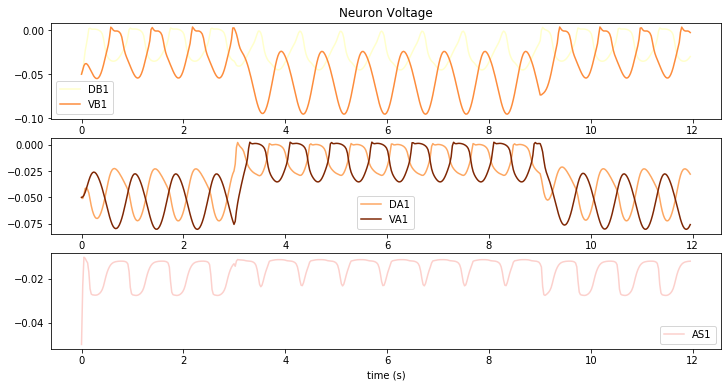

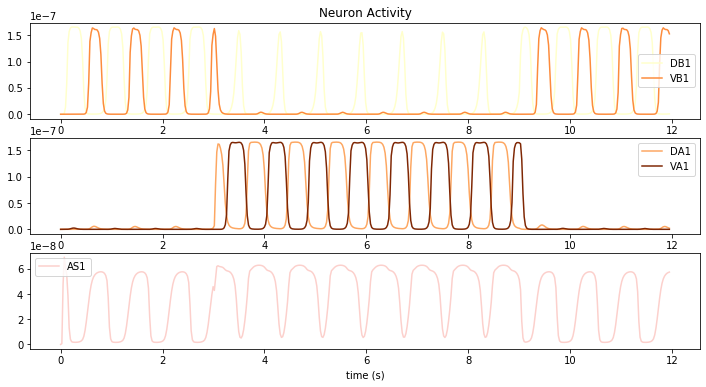

In [429]:
if include_neurons:
    print('Neurons: ')
    print(cells)
    
    data_1 = H_1
    data_2 = H_2
    legend = cells
    
    #################
    # CELLS TO PLOT #
    #################
    
    #'''
    first_cells = ['DB1', 'VB1']
    second_cells = ['VA1', 'DA1']
    third_cells = ['AS1']
    #'''
    
    '''
    range_incl = lambda start, end:range(start, end + 1)
    first_cells = ["DA%s" % c for c in range_incl(1, 15)]
    second_cells = ["VA%s" % c for c in range_incl(1, 15)]
    third_cells = ['AVAR', 'AVAL']
    #third_cells = ["AS%s" % c for c in range_incl(1, 10)]
    #'''
    count = 0
    first_index = []
    second_index = []
    third_index = []
    for i in range(len(cells)):
        if cells[i] in first_cells:
            first_index.append(i)
        elif cells[i] in second_cells:
            second_index.append(i)
        elif cells[i] in third_cells:
            third_index.append(i)
        count = count+1
    
    print(first_index)
    print(second_index)
    print(third_index)
        
    #plot_data(data, legend, title, xlabel, ylabel, ylimits)
    plot_three_data(data_1, legend, 'Neuron Voltage', first_index, second_index, third_index)
    plot_three_data(data_2, legend, 'Neuron Activity', first_index, second_index, third_index)
else:
    print('No neurons to plot')

Neurons: 
['AS1', 'AS10', 'AS11', 'AS2', 'AS3', 'AS4', 'AS5', 'AS6', 'AS7', 'AS8', 'AS9', 'AVAL', 'AVAR', 'AVBL', 'AVBR', 'DA1', 'DA2', 'DA3', 'DA4', 'DA5', 'DA6', 'DA7', 'DA8', 'DA9', 'DB1', 'DB2', 'DB3', 'DB4', 'DB5', 'DB6', 'DB7', 'DD1', 'DD2', 'DD3', 'DD4', 'DD5', 'DD6', 'VA1', 'VA10', 'VA11', 'VA12', 'VA2', 'VA3', 'VA4', 'VA5', 'VA6', 'VA7', 'VA8', 'VA9', 'VB1', 'VB10', 'VB11', 'VB2', 'VB3', 'VB4', 'VB5', 'VB6', 'VB7', 'VB8', 'VB9', 'VD1', 'VD10', 'VD11', 'VD12', 'VD13', 'VD2', 'VD3', 'VD4', 'VD5', 'VD6', 'VD7', 'VD8', 'VD9']
Do you want to plot all neurons? [Y/n]Y


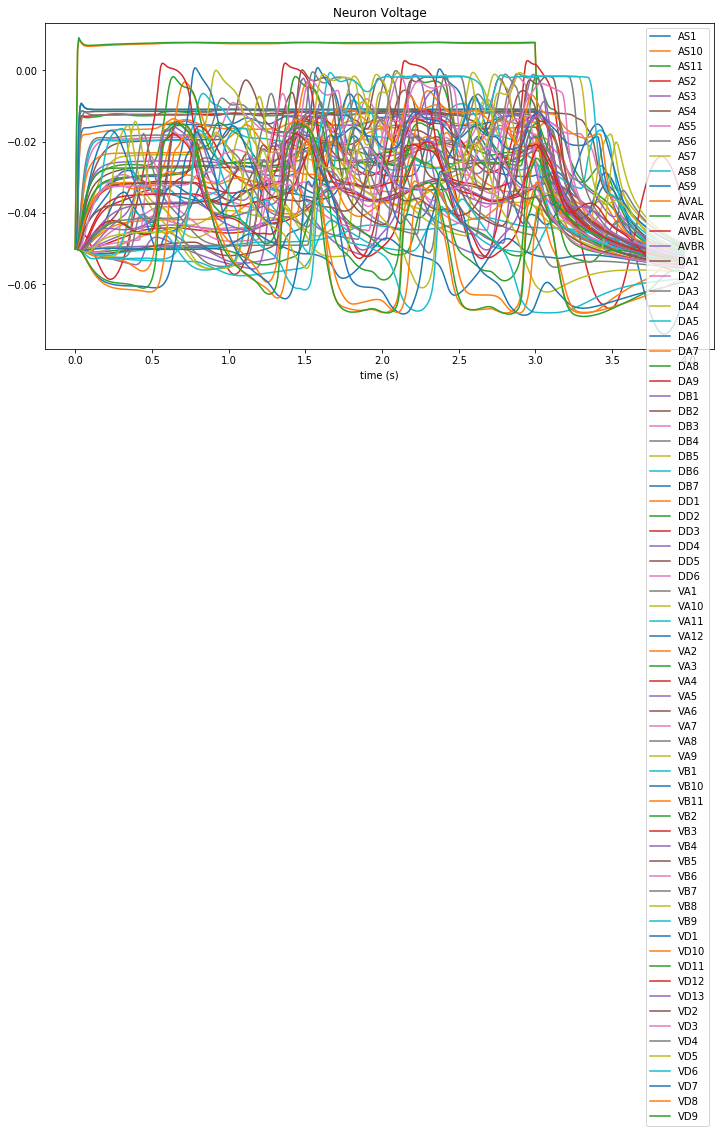

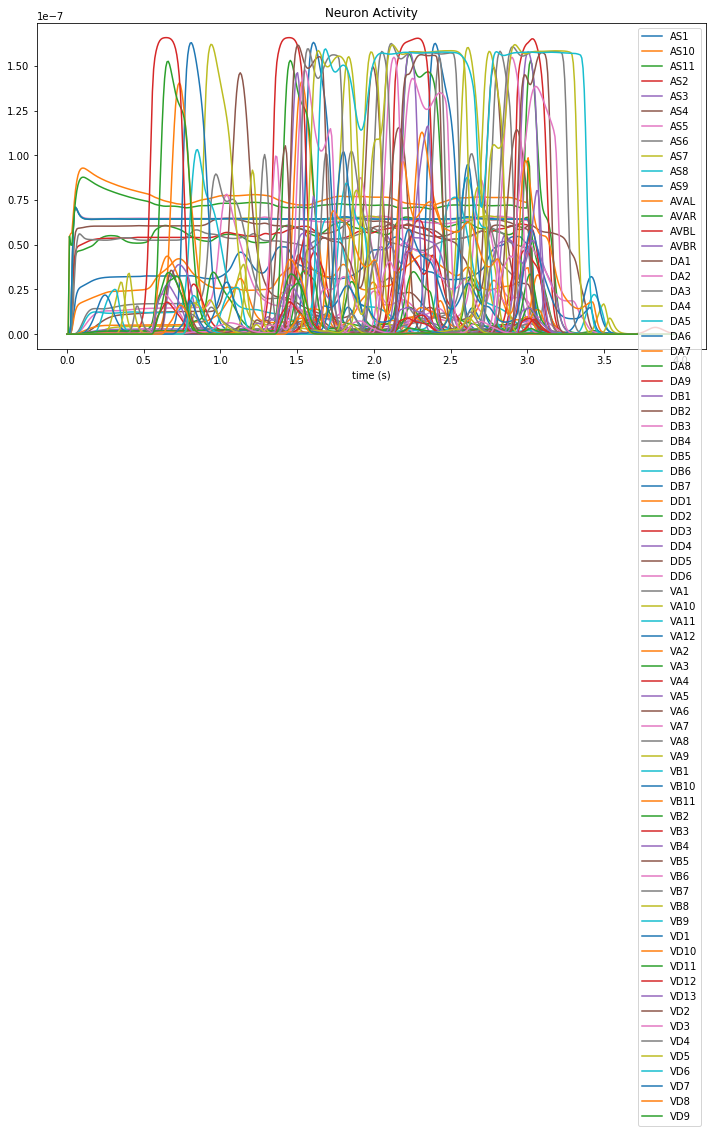

In [86]:
if include_neurons:
    print('Neurons: ')
    print(cells)
    Q1 = input('Do you want to plot all neurons? [Y/n]')
    if Q1 == 'Y':
        plotAll = True
    elif Q1 == 'n':
        plotAll = False
    else: 
        print('Please respond [Y/n]')
    
    if plotAll:
        data_1 = H_1
        data_2 = H_2
        legend = cells
    else:
        
        transp_data_1 = np.transpose(H_1)[0]
        transp_data_2 = np.transpose(H_2)[0]
        
        insertNeurons = True
        cells2 = []
        while insertNeurons:
            Q2 = input('Insert name of one neuron: (q to quit)')
            if Q2 == 'q':
                insertNeurons = False
            elif Q2 in cells:
                cells2.append(Q2)
            else:
                print('Error: Neuron not found in this simulation!')
        
        cells2 = list(set(cells2)) # Delete possible duplicates
        cells2.sort() # Alphabetical order
        
        for i in range(len(cells)):
            if cells[i] in cells2:
                transp_data_1 = np.vstack((transp_data_1, np.transpose(H_1)[i+1]))
                transp_data_2 = np.vstack((transp_data_2, np.transpose(H_2)[i+1]))
        data_1 = np.transpose(transp_data_1)
        data_2 = np.transpose(transp_data_2)
        legend = cells2
        
    #plot_data(data, legend, title, xlabel, ylabel, ylimits)
    plot_data(data_1, legend, 'Neuron Voltage')
    plot_data(data_2, legend, 'Neuron Activity')
else:
    print('No neurons to plot')

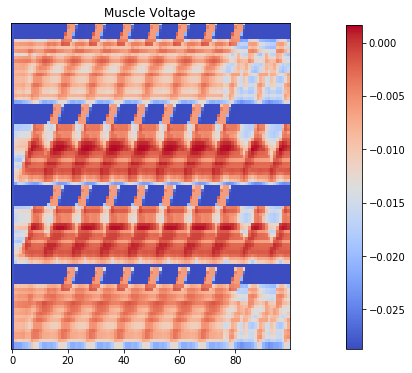

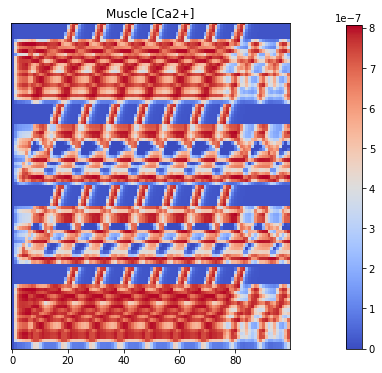

In [415]:
array = np.delete(H_3,0,1)
array2 = np.delete(H_4,0,1)


map_plot(np.transpose(array), 'Muscle Voltage')
map_plot(np.transpose(array2), 'Muscle [Ca2+]')




In [106]:
if include_muscles: 
    H_3 = prepare_array(read_data(muscle_voltage), 100)
    plot_data(H_3)
    H_4 = prepare_array(read_data(muscle_activity), 100)
    plot_data(H_4)
else:
    print('No muscles to plot')

No muscles to plot


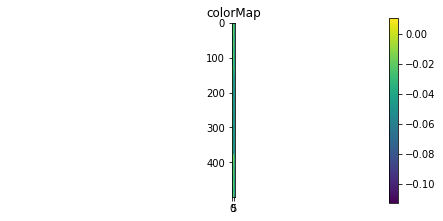

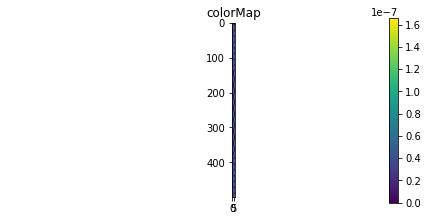

In [107]:
if movement:
    H_1 = read_data(neuron_voltage)
    H_2 = read_data(neuron_activity)
    H_1 = np.delete(H_1,0,1) #Delete time column
    H_2 = np.delete(H_2,0,1)
    H_1 = prepare_array(H_1, 500)
    H_2 = prepare_array(H_2, 500)
    movement_plot(H_1)
    movement_plot(H_2)
    
else:
    print('No movement plot')